In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

In [ ]:
class LayerNorm2d(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(features, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean([1, 2, 3], keepdim=True)
        std = x.std([1, 2, 3], keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

In [ ]:
class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        
        # Simplified Channel Attention
        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, inp):
        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma

In [ ]:
import torch.nn.functional as F

class NAFNetClassification(nn.Module):

    def __init__(self, img_channel=3, width=16, middle_blk_num=1, enc_blk_nums=[], dec_blk_nums=[], num_classes=10):
        super().__init__()

        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                nn.Conv2d(chan, 2*chan, 2, 2)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[NAFBlock(chan) for _ in range(middle_blk_num)]
            )

        for num in dec_blk_nums:
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(chan, chan * 2, 1, bias=False),
                    nn.PixelShuffle(2)
                )
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )

        self.fc = nn.Linear(chan, num_classes)

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp):
        B, C, H, W = inp.shape
        inp = self.check_image_size(inp)

        x = self.intro(inp)

        encs = []

        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encs.append(x)
            x = down(x)

        x = self.middle_blks(x)

        for decoder, up, enc_skip in zip(self.decoders, self.ups, encs[::-1]):
            x = up(x)
            x = x + enc_skip
            x = decoder(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.padder_size - h % self.padder_size) % self.padder_size
        mod_pad_w = (self.padder_size - w % self.padder_size) % self.padder_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), mode='reflect')
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = NAFNetClassification()
model.to(device)

NAFNetClassification(
  (intro): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoders): ModuleList()
  (decoders): ModuleList()
  (middle_blks): Sequential(
    (0): NAFBlock(
      (conv1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (conv3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      (sca): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (sg): SimpleGate()
      (conv4): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (conv5): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      (norm1): LayerNorm2d()
      (norm2): LayerNorm2d()
      (dropout1): Identity()
      (dropout2): Identity()
    )
  )
  (ups): ModuleList()
  (downs): ModuleList()
  (fc): Linear(in_features=16, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# Load the CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:02<00:00, 81665160.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
epochs = 50

Epoch 1:  13%|█▎        | 101/782 [00:25<01:55,  5.90it/s]

[Epoch 1, Batch 100] Loss: 2.279


Epoch 1:  26%|██▌       | 201/782 [00:44<01:41,  5.73it/s]

[Epoch 1, Batch 200] Loss: 2.084


Epoch 1:  38%|███▊      | 301/782 [01:02<01:24,  5.72it/s]

[Epoch 1, Batch 300] Loss: 2.009


Epoch 1:  51%|█████▏    | 401/782 [01:22<01:06,  5.70it/s]

[Epoch 1, Batch 400] Loss: 1.981


Epoch 1:  64%|██████▍   | 501/782 [01:40<00:47,  5.88it/s]

[Epoch 1, Batch 500] Loss: 1.951


Epoch 1:  77%|███████▋  | 600/782 [01:58<00:35,  5.11it/s]

[Epoch 1, Batch 600] Loss: 1.939


Epoch 1:  90%|████████▉ | 701/782 [02:16<00:13,  5.84it/s]

[Epoch 1, Batch 700] Loss: 1.908


Epoch 2:  13%|█▎        | 100/782 [00:18<02:30,  4.52it/s]

[Epoch 2, Batch 100] Loss: 1.884


Epoch 2:  26%|██▌       | 201/782 [00:37<01:41,  5.74it/s]

[Epoch 2, Batch 200] Loss: 1.885


Epoch 2:  38%|███▊      | 300/782 [00:56<01:31,  5.26it/s]

[Epoch 2, Batch 300] Loss: 1.870


Epoch 2:  51%|█████▏    | 401/782 [01:15<01:08,  5.59it/s]

[Epoch 2, Batch 400] Loss: 1.859


Epoch 2:  64%|██████▍   | 501/782 [01:33<00:48,  5.83it/s]

[Epoch 2, Batch 500] Loss: 1.830


Epoch 2:  77%|███████▋  | 601/782 [01:52<00:31,  5.68it/s]

[Epoch 2, Batch 600] Loss: 1.845


Epoch 2:  90%|████████▉ | 701/782 [02:10<00:14,  5.71it/s]

[Epoch 2, Batch 700] Loss: 1.819


Epoch 3:  13%|█▎        | 101/782 [00:19<02:03,  5.50it/s]

[Epoch 3, Batch 100] Loss: 1.794


Epoch 3:  26%|██▌       | 201/782 [00:38<01:41,  5.75it/s]

[Epoch 3, Batch 200] Loss: 1.790


Epoch 3:  38%|███▊      | 300/782 [00:56<01:45,  4.55it/s]

[Epoch 3, Batch 300] Loss: 1.790


Epoch 3:  51%|█████▏    | 401/782 [01:14<01:06,  5.76it/s]

[Epoch 3, Batch 400] Loss: 1.783


Epoch 3:  64%|██████▍   | 501/782 [01:32<00:48,  5.74it/s]

[Epoch 3, Batch 500] Loss: 1.760


Epoch 3:  77%|███████▋  | 601/782 [01:51<00:31,  5.74it/s]

[Epoch 3, Batch 600] Loss: 1.757


Epoch 3:  90%|████████▉ | 701/782 [02:09<00:13,  6.11it/s]

[Epoch 3, Batch 700] Loss: 1.766


Epoch 4:  13%|█▎        | 101/782 [00:21<01:59,  5.70it/s]

[Epoch 4, Batch 100] Loss: 1.741


Epoch 4:  26%|██▌       | 201/782 [00:39<01:38,  5.88it/s]

[Epoch 4, Batch 200] Loss: 1.740


Epoch 4:  38%|███▊      | 301/782 [00:58<01:25,  5.63it/s]

[Epoch 4, Batch 300] Loss: 1.742


Epoch 4:  51%|█████▏    | 401/782 [01:16<01:05,  5.86it/s]

[Epoch 4, Batch 400] Loss: 1.727


Epoch 4:  64%|██████▍   | 500/782 [01:35<01:08,  4.10it/s]

[Epoch 4, Batch 500] Loss: 1.720


Epoch 4:  77%|███████▋  | 601/782 [01:54<00:33,  5.41it/s]

[Epoch 4, Batch 600] Loss: 1.706


Epoch 4:  90%|████████▉ | 701/782 [02:15<00:19,  4.25it/s]

[Epoch 4, Batch 700] Loss: 1.712


Epoch 5:  13%|█▎        | 100/782 [00:19<02:04,  5.46it/s]

[Epoch 5, Batch 100] Loss: 1.700


Epoch 5:  26%|██▌       | 201/782 [00:39<01:44,  5.58it/s]

[Epoch 5, Batch 200] Loss: 1.707


Epoch 5:  38%|███▊      | 300/782 [00:59<01:52,  4.28it/s]

[Epoch 5, Batch 300] Loss: 1.701


Epoch 5:  51%|█████▏    | 401/782 [01:19<01:10,  5.39it/s]

[Epoch 5, Batch 400] Loss: 1.684


Epoch 5:  64%|██████▍   | 501/782 [01:38<00:50,  5.53it/s]

[Epoch 5, Batch 500] Loss: 1.678


Epoch 5:  77%|███████▋  | 601/782 [01:57<00:32,  5.51it/s]

[Epoch 5, Batch 600] Loss: 1.689


Epoch 5:  90%|████████▉ | 701/782 [02:16<00:14,  5.57it/s]

[Epoch 5, Batch 700] Loss: 1.691


Epoch 6:  13%|█▎        | 101/782 [00:19<01:59,  5.71it/s]

[Epoch 6, Batch 100] Loss: 1.681


Epoch 6:  26%|██▌       | 201/782 [00:38<01:42,  5.68it/s]

[Epoch 6, Batch 200] Loss: 1.681


Epoch 6:  38%|███▊      | 301/782 [00:58<01:29,  5.38it/s]

[Epoch 6, Batch 300] Loss: 1.685


Epoch 6:  51%|█████▏    | 401/782 [01:17<01:07,  5.63it/s]

[Epoch 6, Batch 400] Loss: 1.655


Epoch 6:  64%|██████▍   | 501/782 [01:36<00:51,  5.42it/s]

[Epoch 6, Batch 500] Loss: 1.676


Epoch 6:  77%|███████▋  | 601/782 [01:55<00:33,  5.47it/s]

[Epoch 6, Batch 600] Loss: 1.649


Epoch 6:  90%|████████▉ | 701/782 [02:15<00:14,  5.64it/s]

[Epoch 6, Batch 700] Loss: 1.645


Epoch 7:  13%|█▎        | 100/782 [00:19<02:29,  4.55it/s]

[Epoch 7, Batch 100] Loss: 1.654


Epoch 7:  26%|██▌       | 201/782 [00:38<01:41,  5.73it/s]

[Epoch 7, Batch 200] Loss: 1.657


Epoch 7:  38%|███▊      | 301/782 [00:57<01:26,  5.53it/s]

[Epoch 7, Batch 300] Loss: 1.659


Epoch 7:  51%|█████▏    | 401/782 [01:16<01:10,  5.43it/s]

[Epoch 7, Batch 400] Loss: 1.647


Epoch 7:  64%|██████▍   | 501/782 [01:35<00:51,  5.46it/s]

[Epoch 7, Batch 500] Loss: 1.650


Epoch 7:  77%|███████▋  | 601/782 [01:56<00:33,  5.48it/s]

[Epoch 7, Batch 600] Loss: 1.643


Epoch 7:  90%|████████▉ | 701/782 [02:15<00:14,  5.43it/s]

[Epoch 7, Batch 700] Loss: 1.625


Epoch 8:  13%|█▎        | 100/782 [00:19<02:15,  5.03it/s]

[Epoch 8, Batch 100] Loss: 1.635


Epoch 8:  26%|██▌       | 200/782 [00:40<02:06,  4.60it/s]

[Epoch 8, Batch 200] Loss: 1.639


Epoch 8:  38%|███▊      | 301/782 [00:59<01:27,  5.51it/s]

[Epoch 8, Batch 300] Loss: 1.616


Epoch 8:  51%|█████     | 400/782 [01:18<01:26,  4.41it/s]

[Epoch 8, Batch 400] Loss: 1.631


Epoch 8:  64%|██████▍   | 501/782 [01:37<00:49,  5.67it/s]

[Epoch 8, Batch 500] Loss: 1.609


Epoch 8:  77%|███████▋  | 600/782 [01:57<00:41,  4.36it/s]

[Epoch 8, Batch 600] Loss: 1.619


Epoch 8:  90%|████████▉ | 701/782 [02:16<00:15,  5.26it/s]

[Epoch 8, Batch 700] Loss: 1.618


Epoch 9:  13%|█▎        | 101/782 [00:20<02:02,  5.57it/s]

[Epoch 9, Batch 100] Loss: 1.603


Epoch 9:  26%|██▌       | 201/782 [00:39<01:47,  5.42it/s]

[Epoch 9, Batch 200] Loss: 1.634


Epoch 9:  38%|███▊      | 301/782 [00:59<01:28,  5.41it/s]

[Epoch 9, Batch 300] Loss: 1.597


Epoch 9:  51%|█████▏    | 401/782 [01:18<01:09,  5.47it/s]

[Epoch 9, Batch 400] Loss: 1.619


Epoch 9:  64%|██████▍   | 501/782 [01:37<00:50,  5.53it/s]

[Epoch 9, Batch 500] Loss: 1.612


Epoch 9:  77%|███████▋  | 601/782 [01:56<00:33,  5.38it/s]

[Epoch 9, Batch 600] Loss: 1.600


Epoch 9:  90%|████████▉ | 701/782 [02:16<00:15,  5.26it/s]

[Epoch 9, Batch 700] Loss: 1.597


Epoch 10:  13%|█▎        | 100/782 [00:19<02:47,  4.07it/s]

[Epoch 10, Batch 100] Loss: 1.604


Epoch 10:  26%|██▌       | 201/782 [00:39<01:46,  5.47it/s]

[Epoch 10, Batch 200] Loss: 1.587


Epoch 10:  38%|███▊      | 300/782 [00:59<01:55,  4.19it/s]

[Epoch 10, Batch 300] Loss: 1.606


Epoch 10:  51%|█████▏    | 401/782 [01:18<01:08,  5.58it/s]

[Epoch 10, Batch 400] Loss: 1.601


Epoch 10:  64%|██████▍   | 500/782 [01:37<01:10,  3.98it/s]

[Epoch 10, Batch 500] Loss: 1.569


Epoch 10:  77%|███████▋  | 601/782 [01:56<00:32,  5.57it/s]

[Epoch 10, Batch 600] Loss: 1.600


Epoch 10:  90%|████████▉ | 700/782 [02:15<00:17,  4.80it/s]

[Epoch 10, Batch 700] Loss: 1.576


Epoch 11:  13%|█▎        | 101/782 [00:19<02:03,  5.52it/s]

[Epoch 11, Batch 100] Loss: 1.574


Epoch 11:  26%|██▌       | 201/782 [00:38<01:57,  4.92it/s]

[Epoch 11, Batch 200] Loss: 1.575


Epoch 11:  38%|███▊      | 301/782 [00:57<01:25,  5.63it/s]

[Epoch 11, Batch 300] Loss: 1.577


Epoch 11:  51%|█████     | 400/782 [01:16<01:32,  4.12it/s]

[Epoch 11, Batch 400] Loss: 1.575


Epoch 11:  64%|██████▍   | 501/782 [01:35<00:51,  5.45it/s]

[Epoch 11, Batch 500] Loss: 1.587


Epoch 11:  77%|███████▋  | 600/782 [01:53<00:36,  4.97it/s]

[Epoch 11, Batch 600] Loss: 1.592


Epoch 11:  90%|████████▉ | 701/782 [02:13<00:14,  5.55it/s]

[Epoch 11, Batch 700] Loss: 1.554


Epoch 12:  13%|█▎        | 100/782 [00:19<02:41,  4.23it/s]

[Epoch 12, Batch 100] Loss: 1.559


Epoch 12:  26%|██▌       | 201/782 [00:38<01:49,  5.32it/s]

[Epoch 12, Batch 200] Loss: 1.557


Epoch 12:  38%|███▊      | 300/782 [00:58<01:48,  4.44it/s]

[Epoch 12, Batch 300] Loss: 1.567


Epoch 12:  51%|█████▏    | 401/782 [01:17<01:10,  5.37it/s]

[Epoch 12, Batch 400] Loss: 1.543


Epoch 12:  64%|██████▍   | 500/782 [01:36<01:04,  4.39it/s]

[Epoch 12, Batch 500] Loss: 1.542


Epoch 12:  77%|███████▋  | 601/782 [01:55<00:34,  5.31it/s]

[Epoch 12, Batch 600] Loss: 1.558


Epoch 12:  90%|████████▉ | 700/782 [02:14<00:19,  4.29it/s]

[Epoch 12, Batch 700] Loss: 1.517


Epoch 13:  13%|█▎        | 101/782 [00:19<02:04,  5.49it/s]

[Epoch 13, Batch 100] Loss: 1.552


Epoch 13:  26%|██▌       | 201/782 [00:39<01:51,  5.23it/s]

[Epoch 13, Batch 200] Loss: 1.549


Epoch 13:  38%|███▊      | 301/782 [00:57<01:30,  5.34it/s]

[Epoch 13, Batch 300] Loss: 1.542


Epoch 13:  51%|█████▏    | 401/782 [01:17<01:19,  4.82it/s]

[Epoch 13, Batch 400] Loss: 1.534


Epoch 13:  64%|██████▍   | 501/782 [01:35<00:50,  5.60it/s]

[Epoch 13, Batch 500] Loss: 1.508


Epoch 13:  77%|███████▋  | 600/782 [01:54<00:39,  4.58it/s]

[Epoch 13, Batch 600] Loss: 1.532


Epoch 13:  90%|████████▉ | 701/782 [02:13<00:14,  5.50it/s]

[Epoch 13, Batch 700] Loss: 1.524


Epoch 14:  13%|█▎        | 101/782 [00:18<02:02,  5.56it/s]

[Epoch 14, Batch 100] Loss: 1.553


Epoch 14:  26%|██▌       | 201/782 [00:36<01:37,  5.94it/s]

[Epoch 14, Batch 200] Loss: 1.515


Epoch 14:  38%|███▊      | 300/782 [00:54<01:31,  5.28it/s]

[Epoch 14, Batch 300] Loss: 1.520


Epoch 14:  51%|█████▏    | 401/782 [01:13<01:09,  5.48it/s]

[Epoch 14, Batch 400] Loss: 1.514


Epoch 14:  64%|██████▍   | 501/782 [01:32<00:51,  5.49it/s]

[Epoch 14, Batch 500] Loss: 1.526


Epoch 14:  77%|███████▋  | 601/782 [01:51<00:33,  5.43it/s]

[Epoch 14, Batch 600] Loss: 1.496


Epoch 14:  90%|████████▉ | 701/782 [02:10<00:14,  5.47it/s]

[Epoch 14, Batch 700] Loss: 1.496


Epoch 15:  13%|█▎        | 101/782 [00:19<02:04,  5.46it/s]

[Epoch 15, Batch 100] Loss: 1.508


Epoch 15:  26%|██▌       | 200/782 [00:39<02:19,  4.19it/s]

[Epoch 15, Batch 200] Loss: 1.525


Epoch 15:  38%|███▊      | 301/782 [00:58<01:25,  5.60it/s]

[Epoch 15, Batch 300] Loss: 1.485


Epoch 15:  51%|█████     | 400/782 [01:18<01:34,  4.04it/s]

[Epoch 15, Batch 400] Loss: 1.491


Epoch 15:  64%|██████▍   | 501/782 [01:37<00:50,  5.51it/s]

[Epoch 15, Batch 500] Loss: 1.504


Epoch 15:  77%|███████▋  | 600/782 [01:57<00:42,  4.30it/s]

[Epoch 15, Batch 600] Loss: 1.495


Epoch 15:  90%|████████▉ | 701/782 [02:16<00:14,  5.53it/s]

[Epoch 15, Batch 700] Loss: 1.502


Epoch 16:  13%|█▎        | 101/782 [00:20<02:01,  5.62it/s]

[Epoch 16, Batch 100] Loss: 1.497


Epoch 16:  26%|██▌       | 201/782 [00:38<01:45,  5.50it/s]

[Epoch 16, Batch 200] Loss: 1.485


Epoch 16:  38%|███▊      | 301/782 [00:58<01:34,  5.09it/s]

[Epoch 16, Batch 300] Loss: 1.501


Epoch 16:  51%|█████▏    | 401/782 [01:17<01:09,  5.51it/s]

[Epoch 16, Batch 400] Loss: 1.487


Epoch 16:  64%|██████▍   | 501/782 [01:36<01:01,  4.58it/s]

[Epoch 16, Batch 500] Loss: 1.500


Epoch 16:  77%|███████▋  | 601/782 [01:55<00:31,  5.79it/s]

[Epoch 16, Batch 600] Loss: 1.502


Epoch 16:  90%|████████▉ | 700/782 [02:15<00:20,  3.92it/s]

[Epoch 16, Batch 700] Loss: 1.476


Epoch 17:  13%|█▎        | 101/782 [00:20<02:04,  5.46it/s]

[Epoch 17, Batch 100] Loss: 1.450


Epoch 17:  26%|██▌       | 201/782 [00:40<01:47,  5.41it/s]

[Epoch 17, Batch 200] Loss: 1.480


Epoch 17:  38%|███▊      | 300/782 [00:59<01:28,  5.42it/s]

[Epoch 17, Batch 300] Loss: 1.466


Epoch 17:  51%|█████▏    | 401/782 [01:19<01:07,  5.67it/s]

[Epoch 17, Batch 400] Loss: 1.474


Epoch 17:  64%|██████▍   | 500/782 [01:38<00:51,  5.51it/s]

[Epoch 17, Batch 500] Loss: 1.504


Epoch 17:  77%|███████▋  | 601/782 [01:58<00:34,  5.24it/s]

[Epoch 17, Batch 600] Loss: 1.480


Epoch 17:  90%|████████▉ | 701/782 [02:17<00:15,  5.37it/s]

[Epoch 17, Batch 700] Loss: 1.492


Epoch 18:  13%|█▎        | 101/782 [00:19<02:03,  5.51it/s]

[Epoch 18, Batch 100] Loss: 1.482


Epoch 18:  26%|██▌       | 200/782 [00:37<02:14,  4.32it/s]

[Epoch 18, Batch 200] Loss: 1.459


Epoch 18:  38%|███▊      | 301/782 [00:56<01:27,  5.49it/s]

[Epoch 18, Batch 300] Loss: 1.457


Epoch 18:  51%|█████     | 400/782 [01:15<01:21,  4.67it/s]

[Epoch 18, Batch 400] Loss: 1.486


Epoch 18:  64%|██████▍   | 501/782 [01:34<00:49,  5.64it/s]

[Epoch 18, Batch 500] Loss: 1.481


Epoch 18:  77%|███████▋  | 601/782 [01:53<00:32,  5.57it/s]

[Epoch 18, Batch 600] Loss: 1.458


Epoch 18:  90%|████████▉ | 701/782 [02:13<00:14,  5.46it/s]

[Epoch 18, Batch 700] Loss: 1.466


Epoch 19:  13%|█▎        | 101/782 [00:20<02:32,  4.47it/s]

[Epoch 19, Batch 100] Loss: 1.471


Epoch 19:  26%|██▌       | 201/782 [00:38<01:43,  5.60it/s]

[Epoch 19, Batch 200] Loss: 1.462


Epoch 19:  38%|███▊      | 300/782 [00:58<01:57,  4.11it/s]

[Epoch 19, Batch 300] Loss: 1.451


Epoch 19:  51%|█████▏    | 401/782 [01:17<01:09,  5.49it/s]

[Epoch 19, Batch 400] Loss: 1.447


Epoch 19:  64%|██████▍   | 500/782 [01:36<01:07,  4.18it/s]

[Epoch 19, Batch 500] Loss: 1.444


Epoch 19:  77%|███████▋  | 601/782 [01:55<00:31,  5.70it/s]

[Epoch 19, Batch 600] Loss: 1.442


Epoch 19:  90%|████████▉ | 700/782 [02:13<00:15,  5.45it/s]

[Epoch 19, Batch 700] Loss: 1.463


Epoch 20:  13%|█▎        | 101/782 [00:19<02:06,  5.40it/s]

[Epoch 20, Batch 100] Loss: 1.444


Epoch 20:  26%|██▌       | 200/782 [00:38<02:19,  4.18it/s]

[Epoch 20, Batch 200] Loss: 1.430


Epoch 20:  38%|███▊      | 301/782 [00:56<01:27,  5.49it/s]

[Epoch 20, Batch 300] Loss: 1.450


Epoch 20:  51%|█████     | 400/782 [01:15<01:12,  5.28it/s]

[Epoch 20, Batch 400] Loss: 1.458


Epoch 20:  64%|██████▍   | 501/782 [01:34<00:50,  5.53it/s]

[Epoch 20, Batch 500] Loss: 1.449


Epoch 20:  77%|███████▋  | 601/782 [01:52<00:32,  5.64it/s]

[Epoch 20, Batch 600] Loss: 1.453


Epoch 20:  90%|████████▉ | 701/782 [02:12<00:14,  5.69it/s]

[Epoch 20, Batch 700] Loss: 1.444


Epoch 21:  13%|█▎        | 100/782 [00:19<02:29,  4.55it/s]

[Epoch 21, Batch 100] Loss: 1.419


Epoch 21:  26%|██▌       | 201/782 [00:38<01:43,  5.62it/s]

[Epoch 21, Batch 200] Loss: 1.462


Epoch 21:  38%|███▊      | 300/782 [00:57<01:25,  5.64it/s]

[Epoch 21, Batch 300] Loss: 1.445


Epoch 21:  51%|█████▏    | 401/782 [01:16<01:11,  5.35it/s]

[Epoch 21, Batch 400] Loss: 1.444


Epoch 21:  64%|██████▍   | 501/782 [01:35<01:02,  4.50it/s]

[Epoch 21, Batch 500] Loss: 1.431


Epoch 21:  77%|███████▋  | 601/782 [01:55<00:33,  5.41it/s]

[Epoch 21, Batch 600] Loss: 1.476


Epoch 21:  90%|████████▉ | 701/782 [02:15<00:14,  5.65it/s]

[Epoch 21, Batch 700] Loss: 1.428


Epoch 22:  13%|█▎        | 101/782 [00:20<02:02,  5.54it/s]

[Epoch 22, Batch 100] Loss: 1.418


Epoch 22:  26%|██▌       | 201/782 [00:39<01:44,  5.55it/s]

[Epoch 22, Batch 200] Loss: 1.437


Epoch 22:  38%|███▊      | 301/782 [00:57<01:23,  5.75it/s]

[Epoch 22, Batch 300] Loss: 1.437


Epoch 22:  51%|█████     | 400/782 [01:16<01:25,  4.49it/s]

[Epoch 22, Batch 400] Loss: 1.423


Epoch 22:  64%|██████▍   | 501/782 [01:35<00:50,  5.52it/s]

[Epoch 22, Batch 500] Loss: 1.417


Epoch 22:  77%|███████▋  | 601/782 [01:55<00:33,  5.33it/s]

[Epoch 22, Batch 600] Loss: 1.411


Epoch 22:  90%|████████▉ | 701/782 [02:14<00:14,  5.41it/s]

[Epoch 22, Batch 700] Loss: 1.415


Epoch 23:  13%|█▎        | 101/782 [00:19<02:05,  5.45it/s]

[Epoch 23, Batch 100] Loss: 1.425


Epoch 23:  26%|██▌       | 201/782 [00:38<01:47,  5.42it/s]

[Epoch 23, Batch 200] Loss: 1.417


Epoch 23:  38%|███▊      | 301/782 [00:56<01:28,  5.46it/s]

[Epoch 23, Batch 300] Loss: 1.427


Epoch 23:  51%|█████▏    | 401/782 [01:15<01:08,  5.58it/s]

[Epoch 23, Batch 400] Loss: 1.431


Epoch 23:  64%|██████▍   | 501/782 [01:34<00:50,  5.59it/s]

[Epoch 23, Batch 500] Loss: 1.434


Epoch 23:  77%|███████▋  | 601/782 [01:53<00:33,  5.37it/s]

[Epoch 23, Batch 600] Loss: 1.430


Epoch 23:  90%|████████▉ | 700/782 [02:11<00:16,  4.82it/s]

[Epoch 23, Batch 700] Loss: 1.401


Epoch 24:  13%|█▎        | 101/782 [00:18<02:01,  5.61it/s]

[Epoch 24, Batch 100] Loss: 1.412


Epoch 24:  26%|██▌       | 201/782 [00:38<01:43,  5.59it/s]

[Epoch 24, Batch 200] Loss: 1.417


Epoch 24:  38%|███▊      | 301/782 [00:56<01:23,  5.76it/s]

[Epoch 24, Batch 300] Loss: 1.397


Epoch 24:  51%|█████▏    | 401/782 [01:14<01:04,  5.94it/s]

[Epoch 24, Batch 400] Loss: 1.436


Epoch 24:  64%|██████▍   | 501/782 [01:31<00:50,  5.54it/s]

[Epoch 24, Batch 500] Loss: 1.415


Epoch 24:  77%|███████▋  | 601/782 [01:50<00:31,  5.66it/s]

[Epoch 24, Batch 600] Loss: 1.427


Epoch 24:  90%|████████▉ | 701/782 [02:08<00:14,  5.68it/s]

[Epoch 24, Batch 700] Loss: 1.415


Epoch 25:  13%|█▎        | 101/782 [00:18<01:59,  5.69it/s]

[Epoch 25, Batch 100] Loss: 1.399


Epoch 25:  26%|██▌       | 201/782 [00:37<01:47,  5.38it/s]

[Epoch 25, Batch 200] Loss: 1.374


Epoch 25:  38%|███▊      | 301/782 [00:55<01:21,  5.87it/s]

[Epoch 25, Batch 300] Loss: 1.410


Epoch 25:  51%|█████▏    | 401/782 [01:13<01:07,  5.66it/s]

[Epoch 25, Batch 400] Loss: 1.407


Epoch 25:  64%|██████▍   | 501/782 [01:32<00:49,  5.69it/s]

[Epoch 25, Batch 500] Loss: 1.411


Epoch 25:  77%|███████▋  | 601/782 [01:50<00:30,  5.85it/s]

[Epoch 25, Batch 600] Loss: 1.392


Epoch 25:  90%|████████▉ | 701/782 [02:08<00:14,  5.78it/s]

[Epoch 25, Batch 700] Loss: 1.430


Epoch 26:  13%|█▎        | 101/782 [00:18<01:58,  5.76it/s]

[Epoch 26, Batch 100] Loss: 1.390


Epoch 26:  26%|██▌       | 201/782 [00:35<01:37,  5.97it/s]

[Epoch 26, Batch 200] Loss: 1.401


Epoch 26:  38%|███▊      | 301/782 [00:53<01:20,  6.00it/s]

[Epoch 26, Batch 300] Loss: 1.409


Epoch 26:  51%|█████▏    | 401/782 [01:10<01:02,  6.10it/s]

[Epoch 26, Batch 400] Loss: 1.420


Epoch 26:  64%|██████▍   | 501/782 [01:28<00:46,  6.04it/s]

[Epoch 26, Batch 500] Loss: 1.408


Epoch 26:  77%|███████▋  | 601/782 [01:46<00:32,  5.59it/s]

[Epoch 26, Batch 600] Loss: 1.382


Epoch 26:  90%|████████▉ | 701/782 [02:04<00:13,  6.12it/s]

[Epoch 26, Batch 700] Loss: 1.400


Epoch 27:  13%|█▎        | 101/782 [00:17<01:52,  6.04it/s]

[Epoch 27, Batch 100] Loss: 1.410


Epoch 27:  26%|██▌       | 201/782 [00:35<01:37,  5.97it/s]

[Epoch 27, Batch 200] Loss: 1.378


Epoch 27:  38%|███▊      | 301/782 [00:52<01:27,  5.51it/s]

[Epoch 27, Batch 300] Loss: 1.385


Epoch 27:  51%|█████▏    | 401/782 [01:11<01:08,  5.54it/s]

[Epoch 27, Batch 400] Loss: 1.403


Epoch 27:  64%|██████▍   | 500/782 [01:30<01:01,  4.60it/s]

[Epoch 27, Batch 500] Loss: 1.409


Epoch 27:  77%|███████▋  | 601/782 [01:50<00:33,  5.40it/s]

[Epoch 27, Batch 600] Loss: 1.386


Epoch 27:  90%|████████▉ | 701/782 [02:09<00:16,  4.88it/s]

[Epoch 27, Batch 700] Loss: 1.385


Epoch 28:  13%|█▎        | 101/782 [00:18<02:01,  5.61it/s]

[Epoch 28, Batch 100] Loss: 1.409


Epoch 28:  26%|██▌       | 201/782 [00:37<01:42,  5.69it/s]

[Epoch 28, Batch 200] Loss: 1.401


Epoch 28:  38%|███▊      | 300/782 [00:55<01:30,  5.30it/s]

[Epoch 28, Batch 300] Loss: 1.380


Epoch 28:  51%|█████▏    | 401/782 [01:13<01:06,  5.75it/s]

[Epoch 28, Batch 400] Loss: 1.396


Epoch 28:  64%|██████▍   | 500/782 [01:32<01:01,  4.57it/s]

[Epoch 28, Batch 500] Loss: 1.393


Epoch 28:  77%|███████▋  | 601/782 [01:50<00:30,  5.94it/s]

[Epoch 28, Batch 600] Loss: 1.372


Epoch 28:  90%|████████▉ | 701/782 [02:07<00:14,  5.61it/s]

[Epoch 28, Batch 700] Loss: 1.365


Epoch 29:  13%|█▎        | 101/782 [00:17<01:52,  6.03it/s]

[Epoch 29, Batch 100] Loss: 1.395


Epoch 29:  26%|██▌       | 200/782 [00:35<02:06,  4.59it/s]

[Epoch 29, Batch 200] Loss: 1.358


Epoch 29:  38%|███▊      | 301/782 [00:53<01:22,  5.85it/s]

[Epoch 29, Batch 300] Loss: 1.376


Epoch 29:  51%|█████     | 400/782 [01:10<01:21,  4.69it/s]

[Epoch 29, Batch 400] Loss: 1.393


Epoch 29:  64%|██████▍   | 501/782 [01:28<00:47,  5.88it/s]

[Epoch 29, Batch 500] Loss: 1.369


Epoch 29:  77%|███████▋  | 600/782 [01:45<00:33,  5.37it/s]

[Epoch 29, Batch 600] Loss: 1.391


Epoch 29:  90%|████████▉ | 701/782 [02:03<00:13,  6.04it/s]

[Epoch 29, Batch 700] Loss: 1.386


Epoch 30:  13%|█▎        | 101/782 [00:18<02:29,  4.55it/s]

[Epoch 30, Batch 100] Loss: 1.356


Epoch 30:  26%|██▌       | 201/782 [00:36<01:41,  5.73it/s]

[Epoch 30, Batch 200] Loss: 1.377


Epoch 30:  38%|███▊      | 301/782 [00:55<01:29,  5.39it/s]

[Epoch 30, Batch 300] Loss: 1.355


Epoch 30:  51%|█████▏    | 401/782 [01:13<01:07,  5.66it/s]

[Epoch 30, Batch 400] Loss: 1.394


Epoch 30:  64%|██████▍   | 501/782 [01:32<00:48,  5.76it/s]

[Epoch 30, Batch 500] Loss: 1.384


Epoch 30:  77%|███████▋  | 601/782 [01:50<00:31,  5.73it/s]

[Epoch 30, Batch 600] Loss: 1.364


Epoch 30:  90%|████████▉ | 701/782 [02:09<00:14,  5.60it/s]

[Epoch 30, Batch 700] Loss: 1.388


Epoch 31:  13%|█▎        | 100/782 [00:18<02:41,  4.21it/s]

[Epoch 31, Batch 100] Loss: 1.374


Epoch 31:  26%|██▌       | 201/782 [00:37<01:43,  5.63it/s]

[Epoch 31, Batch 200] Loss: 1.358


Epoch 31:  38%|███▊      | 301/782 [00:55<01:32,  5.20it/s]

[Epoch 31, Batch 300] Loss: 1.379


Epoch 31:  51%|█████▏    | 401/782 [01:14<01:07,  5.62it/s]

[Epoch 31, Batch 400] Loss: 1.356


Epoch 31:  64%|██████▍   | 501/782 [01:32<00:47,  5.89it/s]

[Epoch 31, Batch 500] Loss: 1.374


Epoch 31:  77%|███████▋  | 601/782 [01:50<00:30,  5.84it/s]

[Epoch 31, Batch 600] Loss: 1.362


Epoch 31:  90%|████████▉ | 701/782 [02:08<00:14,  5.46it/s]

[Epoch 31, Batch 700] Loss: 1.388


Epoch 32:  13%|█▎        | 100/782 [00:18<02:08,  5.30it/s]

[Epoch 32, Batch 100] Loss: 1.383


Epoch 32:  26%|██▌       | 201/782 [00:36<01:38,  5.93it/s]

[Epoch 32, Batch 200] Loss: 1.375


Epoch 32:  38%|███▊      | 301/782 [00:54<01:25,  5.60it/s]

[Epoch 32, Batch 300] Loss: 1.354


Epoch 32:  51%|█████▏    | 401/782 [01:12<01:05,  5.82it/s]

[Epoch 32, Batch 400] Loss: 1.370


Epoch 32:  64%|██████▍   | 501/782 [01:30<00:48,  5.80it/s]

[Epoch 32, Batch 500] Loss: 1.366


Epoch 32:  77%|███████▋  | 601/782 [01:48<00:30,  5.95it/s]

[Epoch 32, Batch 600] Loss: 1.361


Epoch 32:  90%|████████▉ | 701/782 [02:05<00:13,  5.95it/s]

[Epoch 32, Batch 700] Loss: 1.358


Epoch 33:  13%|█▎        | 101/782 [00:18<01:49,  6.19it/s]

[Epoch 33, Batch 100] Loss: 1.339


Epoch 33:  26%|██▌       | 201/782 [00:37<01:48,  5.34it/s]

[Epoch 33, Batch 200] Loss: 1.349


Epoch 33:  38%|███▊      | 301/782 [00:56<01:26,  5.59it/s]

[Epoch 33, Batch 300] Loss: 1.377


Epoch 33:  51%|█████▏    | 401/782 [01:15<01:12,  5.23it/s]

[Epoch 33, Batch 400] Loss: 1.378


Epoch 33:  64%|██████▍   | 501/782 [01:33<00:50,  5.60it/s]

[Epoch 33, Batch 500] Loss: 1.374


Epoch 33:  77%|███████▋  | 601/782 [01:52<00:33,  5.47it/s]

[Epoch 33, Batch 600] Loss: 1.361


Epoch 33:  90%|████████▉ | 701/782 [02:10<00:14,  5.67it/s]

[Epoch 33, Batch 700] Loss: 1.355


Epoch 34:  13%|█▎        | 101/782 [00:18<01:59,  5.70it/s]

[Epoch 34, Batch 100] Loss: 1.366


Epoch 34:  26%|██▌       | 201/782 [00:37<01:45,  5.53it/s]

[Epoch 34, Batch 200] Loss: 1.357


Epoch 34:  38%|███▊      | 301/782 [00:56<01:25,  5.61it/s]

[Epoch 34, Batch 300] Loss: 1.363


Epoch 34:  51%|█████▏    | 401/782 [01:15<01:03,  5.97it/s]

[Epoch 34, Batch 400] Loss: 1.351


Epoch 34:  64%|██████▍   | 501/782 [01:32<00:47,  5.97it/s]

[Epoch 34, Batch 500] Loss: 1.360


Epoch 34:  77%|███████▋  | 601/782 [01:50<00:31,  5.75it/s]

[Epoch 34, Batch 600] Loss: 1.365


Epoch 34:  90%|████████▉ | 701/782 [02:08<00:13,  5.87it/s]

[Epoch 34, Batch 700] Loss: 1.381


Epoch 35:  13%|█▎        | 101/782 [00:18<02:06,  5.40it/s]

[Epoch 35, Batch 100] Loss: 1.356


Epoch 35:  26%|██▌       | 201/782 [00:36<01:55,  5.04it/s]

[Epoch 35, Batch 200] Loss: 1.373


Epoch 35:  38%|███▊      | 301/782 [00:54<01:20,  5.95it/s]

[Epoch 35, Batch 300] Loss: 1.347


Epoch 35:  51%|█████     | 400/782 [01:12<01:21,  4.71it/s]

[Epoch 35, Batch 400] Loss: 1.364


Epoch 35:  64%|██████▍   | 501/782 [01:29<00:48,  5.85it/s]

[Epoch 35, Batch 500] Loss: 1.356


Epoch 35:  77%|███████▋  | 600/782 [01:47<00:37,  4.86it/s]

[Epoch 35, Batch 600] Loss: 1.346


Epoch 35:  90%|████████▉ | 701/782 [02:06<00:14,  5.57it/s]

[Epoch 35, Batch 700] Loss: 1.364


Epoch 36:  13%|█▎        | 101/782 [00:19<02:00,  5.65it/s]

[Epoch 36, Batch 100] Loss: 1.354


Epoch 36:  26%|██▌       | 201/782 [00:37<01:44,  5.56it/s]

[Epoch 36, Batch 200] Loss: 1.369


Epoch 36:  38%|███▊      | 301/782 [00:56<01:24,  5.70it/s]

[Epoch 36, Batch 300] Loss: 1.357


Epoch 36:  51%|█████     | 400/782 [01:15<01:27,  4.34it/s]

[Epoch 36, Batch 400] Loss: 1.330


Epoch 36:  64%|██████▍   | 501/782 [01:33<00:49,  5.70it/s]

[Epoch 36, Batch 500] Loss: 1.334


Epoch 36:  77%|███████▋  | 601/782 [01:52<00:37,  4.82it/s]

[Epoch 36, Batch 600] Loss: 1.346


Epoch 36:  90%|████████▉ | 701/782 [02:10<00:14,  5.59it/s]

[Epoch 36, Batch 700] Loss: 1.335


Epoch 37:  13%|█▎        | 101/782 [00:19<01:59,  5.69it/s]

[Epoch 37, Batch 100] Loss: 1.342


Epoch 37:  26%|██▌       | 200/782 [00:37<01:45,  5.50it/s]

[Epoch 37, Batch 200] Loss: 1.363


Epoch 37:  38%|███▊      | 301/782 [00:54<01:22,  5.85it/s]

[Epoch 37, Batch 300] Loss: 1.335


Epoch 37:  51%|█████     | 400/782 [01:13<01:20,  4.77it/s]

[Epoch 37, Batch 400] Loss: 1.361


Epoch 37:  64%|██████▍   | 501/782 [01:32<00:49,  5.64it/s]

[Epoch 37, Batch 500] Loss: 1.339


Epoch 37:  77%|███████▋  | 601/782 [01:52<00:34,  5.26it/s]

[Epoch 37, Batch 600] Loss: 1.345


Epoch 37:  90%|████████▉ | 701/782 [02:11<00:15,  5.28it/s]

[Epoch 37, Batch 700] Loss: 1.362


Epoch 38:  13%|█▎        | 101/782 [00:18<02:02,  5.58it/s]

[Epoch 38, Batch 100] Loss: 1.339


Epoch 38:  26%|██▌       | 201/782 [00:37<01:43,  5.59it/s]

[Epoch 38, Batch 200] Loss: 1.331


Epoch 38:  38%|███▊      | 300/782 [00:55<01:29,  5.39it/s]

[Epoch 38, Batch 300] Loss: 1.339


Epoch 38:  51%|█████▏    | 401/782 [01:14<01:07,  5.66it/s]

[Epoch 38, Batch 400] Loss: 1.338


Epoch 38:  64%|██████▍   | 501/782 [01:33<00:48,  5.77it/s]

[Epoch 38, Batch 500] Loss: 1.345


Epoch 38:  77%|███████▋  | 601/782 [01:51<00:32,  5.54it/s]

[Epoch 38, Batch 600] Loss: 1.345


Epoch 38:  90%|████████▉ | 701/782 [02:10<00:14,  5.57it/s]

[Epoch 38, Batch 700] Loss: 1.345


Epoch 39:  13%|█▎        | 101/782 [00:18<02:03,  5.51it/s]

[Epoch 39, Batch 100] Loss: 1.328


Epoch 39:  26%|██▌       | 201/782 [00:37<01:44,  5.56it/s]

[Epoch 39, Batch 200] Loss: 1.328


Epoch 39:  38%|███▊      | 301/782 [00:55<01:27,  5.53it/s]

[Epoch 39, Batch 300] Loss: 1.355


Epoch 39:  51%|█████▏    | 401/782 [01:14<01:06,  5.76it/s]

[Epoch 39, Batch 400] Loss: 1.336


Epoch 39:  64%|██████▍   | 501/782 [01:32<00:50,  5.58it/s]

[Epoch 39, Batch 500] Loss: 1.352


Epoch 39:  77%|███████▋  | 601/782 [01:51<00:32,  5.64it/s]

[Epoch 39, Batch 600] Loss: 1.358


Epoch 39:  90%|████████▉ | 701/782 [02:09<00:14,  5.60it/s]

[Epoch 39, Batch 700] Loss: 1.317


Epoch 40:  13%|█▎        | 101/782 [00:18<02:00,  5.64it/s]

[Epoch 40, Batch 100] Loss: 1.353


Epoch 40:  26%|██▌       | 201/782 [00:37<01:46,  5.43it/s]

[Epoch 40, Batch 200] Loss: 1.344


Epoch 40:  38%|███▊      | 301/782 [00:56<01:27,  5.49it/s]

[Epoch 40, Batch 300] Loss: 1.360


Epoch 40:  51%|█████▏    | 401/782 [01:15<01:08,  5.55it/s]

[Epoch 40, Batch 400] Loss: 1.336


Epoch 40:  64%|██████▍   | 500/782 [01:34<00:59,  4.76it/s]

[Epoch 40, Batch 500] Loss: 1.319


Epoch 40:  77%|███████▋  | 601/782 [01:53<00:32,  5.64it/s]

[Epoch 40, Batch 600] Loss: 1.319


Epoch 40:  90%|████████▉ | 700/782 [02:11<00:18,  4.43it/s]

[Epoch 40, Batch 700] Loss: 1.339


Epoch 41:  13%|█▎        | 101/782 [00:18<02:01,  5.58it/s]

[Epoch 41, Batch 100] Loss: 1.333


Epoch 41:  26%|██▌       | 201/782 [00:37<01:44,  5.55it/s]

[Epoch 41, Batch 200] Loss: 1.346


Epoch 41:  38%|███▊      | 300/782 [00:55<01:29,  5.38it/s]

[Epoch 41, Batch 300] Loss: 1.355


Epoch 41:  51%|█████▏    | 401/782 [01:15<01:07,  5.61it/s]

[Epoch 41, Batch 400] Loss: 1.312


Epoch 41:  64%|██████▍   | 500/782 [01:33<01:03,  4.42it/s]

[Epoch 41, Batch 500] Loss: 1.348


Epoch 41:  77%|███████▋  | 601/782 [01:52<00:32,  5.60it/s]

[Epoch 41, Batch 600] Loss: 1.315


Epoch 41:  90%|████████▉ | 701/782 [02:10<00:15,  5.06it/s]

[Epoch 41, Batch 700] Loss: 1.330


Epoch 42:  13%|█▎        | 101/782 [00:18<02:02,  5.56it/s]

[Epoch 42, Batch 100] Loss: 1.344


Epoch 42:  26%|██▌       | 201/782 [00:37<01:42,  5.69it/s]

[Epoch 42, Batch 200] Loss: 1.307


Epoch 42:  38%|███▊      | 300/782 [00:55<01:30,  5.32it/s]

[Epoch 42, Batch 300] Loss: 1.330


Epoch 42:  51%|█████▏    | 401/782 [01:14<01:06,  5.75it/s]

[Epoch 42, Batch 400] Loss: 1.329


Epoch 42:  64%|██████▍   | 500/782 [01:32<01:01,  4.56it/s]

[Epoch 42, Batch 500] Loss: 1.305


Epoch 42:  77%|███████▋  | 601/782 [01:51<00:32,  5.59it/s]

[Epoch 42, Batch 600] Loss: 1.345


Epoch 42:  90%|████████▉ | 701/782 [02:10<00:17,  4.64it/s]

[Epoch 42, Batch 700] Loss: 1.325


Epoch 43:  13%|█▎        | 100/782 [00:18<02:01,  5.64it/s]

[Epoch 43, Batch 100] Loss: 1.341


Epoch 43:  26%|██▌       | 201/782 [00:37<01:42,  5.69it/s]

[Epoch 43, Batch 200] Loss: 1.315


Epoch 43:  38%|███▊      | 300/782 [00:56<01:47,  4.49it/s]

[Epoch 43, Batch 300] Loss: 1.336


Epoch 43:  51%|█████▏    | 401/782 [01:15<01:07,  5.63it/s]

[Epoch 43, Batch 400] Loss: 1.310


Epoch 43:  64%|██████▍   | 501/782 [01:33<00:56,  5.01it/s]

[Epoch 43, Batch 500] Loss: 1.312


Epoch 43:  77%|███████▋  | 601/782 [01:52<00:32,  5.59it/s]

[Epoch 43, Batch 600] Loss: 1.321


Epoch 43:  90%|████████▉ | 701/782 [02:10<00:14,  5.53it/s]

[Epoch 43, Batch 700] Loss: 1.346


Epoch 44:  13%|█▎        | 100/782 [00:19<02:29,  4.55it/s]

[Epoch 44, Batch 100] Loss: 1.314


Epoch 44:  26%|██▌       | 201/782 [00:37<01:45,  5.51it/s]

[Epoch 44, Batch 200] Loss: 1.336


Epoch 44:  38%|███▊      | 301/782 [00:56<01:35,  5.02it/s]

[Epoch 44, Batch 300] Loss: 1.310


Epoch 44:  51%|█████▏    | 401/782 [01:15<01:08,  5.58it/s]

[Epoch 44, Batch 400] Loss: 1.339


Epoch 44:  64%|██████▍   | 501/782 [01:33<00:53,  5.25it/s]

[Epoch 44, Batch 500] Loss: 1.317


Epoch 44:  77%|███████▋  | 601/782 [01:51<00:31,  5.78it/s]

[Epoch 44, Batch 600] Loss: 1.324


Epoch 44:  90%|████████▉ | 701/782 [02:10<00:14,  5.57it/s]

[Epoch 44, Batch 700] Loss: 1.337


Epoch 45:  13%|█▎        | 100/782 [00:18<02:38,  4.31it/s]

[Epoch 45, Batch 100] Loss: 1.319


Epoch 45:  26%|██▌       | 201/782 [00:37<01:40,  5.76it/s]

[Epoch 45, Batch 200] Loss: 1.311


Epoch 45:  38%|███▊      | 300/782 [00:55<01:47,  4.49it/s]

[Epoch 45, Batch 300] Loss: 1.343


Epoch 45:  51%|█████▏    | 401/782 [01:14<01:08,  5.55it/s]

[Epoch 45, Batch 400] Loss: 1.296


Epoch 45:  64%|██████▍   | 501/782 [01:33<00:53,  5.28it/s]

[Epoch 45, Batch 500] Loss: 1.333


Epoch 45:  77%|███████▋  | 601/782 [01:51<00:32,  5.56it/s]

[Epoch 45, Batch 600] Loss: 1.292


Epoch 45:  90%|████████▉ | 701/782 [02:09<00:14,  5.50it/s]

[Epoch 45, Batch 700] Loss: 1.303


Epoch 46:  13%|█▎        | 100/782 [00:18<02:25,  4.67it/s]

[Epoch 46, Batch 100] Loss: 1.300


Epoch 46:  26%|██▌       | 201/782 [00:37<01:42,  5.67it/s]

[Epoch 46, Batch 200] Loss: 1.320


Epoch 46:  38%|███▊      | 300/782 [00:56<01:52,  4.28it/s]

[Epoch 46, Batch 300] Loss: 1.306


Epoch 46:  51%|█████▏    | 401/782 [01:14<01:07,  5.64it/s]

[Epoch 46, Batch 400] Loss: 1.321


Epoch 46:  64%|██████▍   | 501/782 [01:32<00:53,  5.24it/s]

[Epoch 46, Batch 500] Loss: 1.296


Epoch 46:  77%|███████▋  | 601/782 [01:51<00:32,  5.50it/s]

[Epoch 46, Batch 600] Loss: 1.318


Epoch 46:  90%|████████▉ | 701/782 [02:09<00:14,  5.43it/s]

[Epoch 46, Batch 700] Loss: 1.317


Epoch 47:  13%|█▎        | 100/782 [00:18<02:21,  4.81it/s]

[Epoch 47, Batch 100] Loss: 1.320


Epoch 47:  26%|██▌       | 201/782 [00:37<01:42,  5.66it/s]

[Epoch 47, Batch 200] Loss: 1.312


Epoch 47:  38%|███▊      | 300/782 [00:55<01:49,  4.38it/s]

[Epoch 47, Batch 300] Loss: 1.316


Epoch 47:  51%|█████▏    | 401/782 [01:14<01:08,  5.56it/s]

[Epoch 47, Batch 400] Loss: 1.329


Epoch 47:  64%|██████▍   | 501/782 [01:33<00:55,  5.04it/s]

[Epoch 47, Batch 500] Loss: 1.302


Epoch 47:  77%|███████▋  | 601/782 [01:52<00:34,  5.30it/s]

[Epoch 47, Batch 600] Loss: 1.281


Epoch 47:  90%|████████▉ | 701/782 [02:12<00:15,  5.30it/s]

[Epoch 47, Batch 700] Loss: 1.289


Epoch 48:  13%|█▎        | 101/782 [00:19<02:06,  5.39it/s]

[Epoch 48, Batch 100] Loss: 1.310


Epoch 48:  26%|██▌       | 201/782 [00:38<01:50,  5.27it/s]

[Epoch 48, Batch 200] Loss: 1.306


Epoch 48:  38%|███▊      | 300/782 [00:57<01:28,  5.43it/s]

[Epoch 48, Batch 300] Loss: 1.289


Epoch 48:  51%|█████     | 400/782 [01:18<01:34,  4.05it/s]

[Epoch 48, Batch 400] Loss: 1.317


Epoch 48:  64%|██████▍   | 501/782 [01:37<00:53,  5.28it/s]

[Epoch 48, Batch 500] Loss: 1.330


Epoch 48:  77%|███████▋  | 601/782 [01:57<00:31,  5.71it/s]

[Epoch 48, Batch 600] Loss: 1.314


Epoch 48:  90%|████████▉ | 701/782 [02:16<00:14,  5.62it/s]

[Epoch 48, Batch 700] Loss: 1.295


Epoch 49:  13%|█▎        | 101/782 [00:19<02:07,  5.33it/s]

[Epoch 49, Batch 100] Loss: 1.297


Epoch 49:  26%|██▌       | 201/782 [00:38<01:50,  5.28it/s]

[Epoch 49, Batch 200] Loss: 1.300


Epoch 49:  38%|███▊      | 301/782 [00:57<01:30,  5.31it/s]

[Epoch 49, Batch 300] Loss: 1.302


Epoch 49:  51%|█████▏    | 401/782 [01:16<01:07,  5.67it/s]

[Epoch 49, Batch 400] Loss: 1.301


Epoch 49:  64%|██████▍   | 501/782 [01:35<00:53,  5.24it/s]

[Epoch 49, Batch 500] Loss: 1.312


Epoch 49:  77%|███████▋  | 601/782 [01:54<00:32,  5.57it/s]

[Epoch 49, Batch 600] Loss: 1.305


Epoch 49:  90%|████████▉ | 700/782 [02:13<00:17,  4.63it/s]

[Epoch 49, Batch 700] Loss: 1.316


Epoch 50:  13%|█▎        | 101/782 [00:19<02:03,  5.52it/s]

[Epoch 50, Batch 100] Loss: 1.311


Epoch 50:  26%|██▌       | 201/782 [00:38<01:44,  5.58it/s]

[Epoch 50, Batch 200] Loss: 1.303


Epoch 50:  38%|███▊      | 300/782 [00:57<01:52,  4.28it/s]

[Epoch 50, Batch 300] Loss: 1.312


Epoch 50:  51%|█████▏    | 401/782 [01:16<01:08,  5.56it/s]

[Epoch 50, Batch 400] Loss: 1.310


Epoch 50:  64%|██████▍   | 501/782 [01:34<00:59,  4.71it/s]

[Epoch 50, Batch 500] Loss: 1.300


Epoch 50:  77%|███████▋  | 601/782 [01:53<00:32,  5.65it/s]

[Epoch 50, Batch 600] Loss: 1.281


Epoch 50:  90%|████████▉ | 701/782 [02:12<00:14,  5.69it/s]

[Epoch 50, Batch 700] Loss: 1.277


Epoch 50: 100%|██████████| 782/782 [02:27<00:00,  5.30it/s]


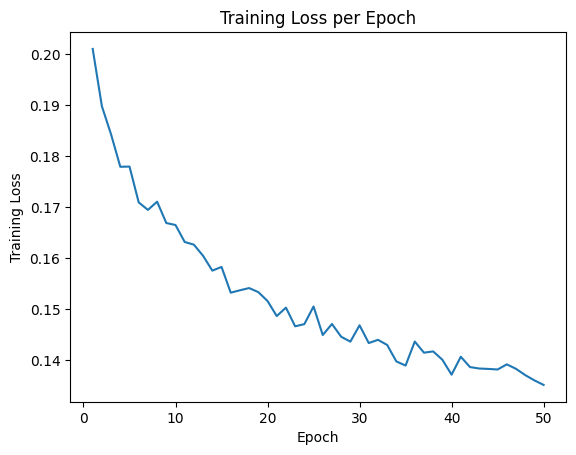

In [ ]:
import matplotlib.pyplot as plt

# Initialize an empty list to store the epoch losses
epoch_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}"), 0):
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss/100:.3f}")
            running_loss = 0.0

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(trainloader)
    epoch_losses.append(epoch_loss)

# Plot the training loss
plt.plot(range(1, epochs+1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch')
plt.show()


In [ ]:
correct = 0
total = 0
true_positives = 0
false_positives = 0
false_negatives = 0
positive_label = 1  # Replace with the appropriate positive label for your task

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in tqdm(testloader, desc="Testing"):
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Predict the outputs
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Compute the accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Compute true positives, false positives, and false negatives
        true_positives += ((predicted == labels) & (predicted == positive_label)).sum().item()
        false_positives += ((predicted != labels) & (predicted == positive_label)).sum().item()
        false_negatives += ((predicted != labels) & (predicted != positive_label)).sum().item()

        # Append true and predicted labels to the respective lists
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

accuracy = 100 * correct / total
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print(f"Accuracy on the test set: {accuracy:.2f}%")

# Print true and predicted labels
print("True Labels:", true_labels)
print("Predicted Labels:", predicted_labels)


Testing: 100%|██████████| 157/157 [00:11<00:00, 13.74it/s]

Accuracy on the test set: 53.20%
True Labels: [3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 6, 8, 6, 8, 0, 4, 0, 7, 7,

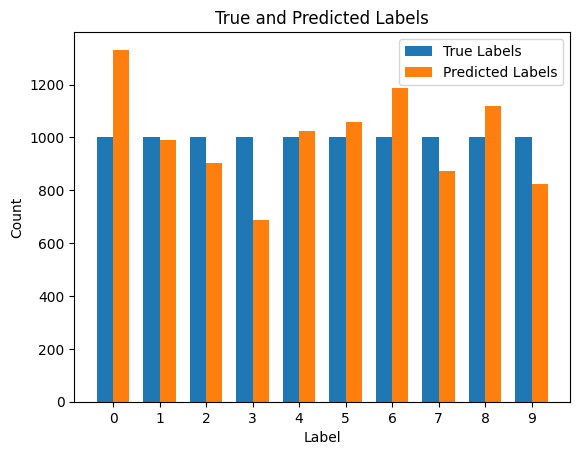

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Count the occurrences of each label
true_label_counts = np.bincount(true_labels)
predicted_label_counts = np.bincount(predicted_labels)

# Get the unique labels
labels = np.unique(np.concatenate((true_labels, predicted_labels)))

# Set the bar width
bar_width = 0.35

# Set the x positions for the bars
x = np.arange(len(labels))

# Plot the true label counts
plt.bar(x, true_label_counts, width=bar_width, label='True Labels')

# Plot the predicted label counts
plt.bar(x + bar_width, predicted_label_counts, width=bar_width, label='Predicted Labels')

# Set the x-axis labels
plt.xticks(x + bar_width / 2, labels)

# Set the plot title and axes labels
plt.title('True and Predicted Labels')
plt.xlabel('Label')
plt.ylabel('Count')

# Display the legend
plt.legend()

# Show the plot
plt.show()


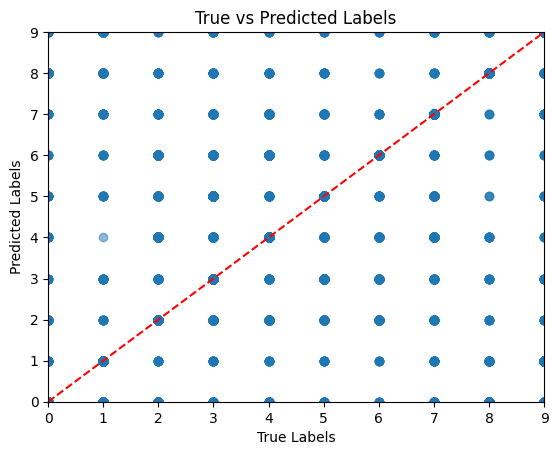

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Plot the true and predicted values
plt.scatter(true_labels, predicted_labels, alpha=0.5)

# Set the plot title and axes labels
plt.title('True vs Predicted Labels')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

# Set the plot limits
min_value = min(np.min(true_labels), np.min(predicted_labels))
max_value = max(np.max(true_labels), np.max(predicted_labels))
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)

# Add a diagonal line for reference
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')

# Show the plot
plt.show()


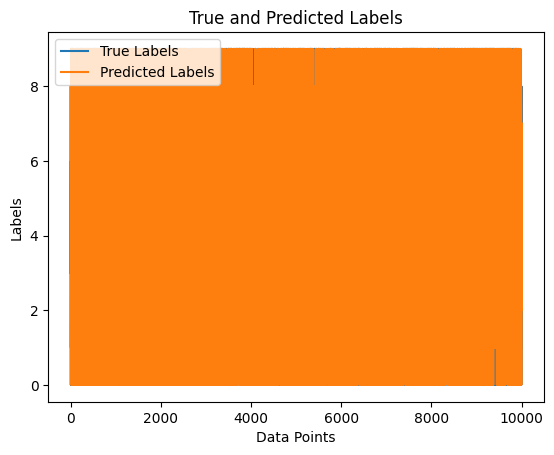

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the x-axis values (indices of the data points)
x = np.arange(len(true_labels))

# Plot the true labels
plt.plot(x, true_labels, label='True Labels')

# Plot the predicted labels
plt.plot(x, predicted_labels, label='Predicted Labels')

# Set the plot title and axes labels
plt.title('True and Predicted Labels')
plt.xlabel('Data Points')
plt.ylabel('Labels')

# Add a legend
plt.legend()

# Show the plot
plt.show()
